In [1]:
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import spacy as sp
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from spacy.tokens import Doc
from sklearn.utils import resample

%matplotlib inline

In [ ]:
# Vantage news API Key
with open('./env', mode='r', encoding='utf-8') as f:
    api_key = f.readline().split('=')[-1]

i = 0

# 30 days of financial news (FREE tier only allows 25 requests/day, hence, only 25 days of data is collected).
while (i < 29):
    time_from = f'202211{'0' + str(i + 1) if i + 1 < 10 else str(i + 1)}T0001'
    time_to = f'202211{'0' + str(i + 2) if i + 2 < 10 else str(i + 2)}T0000'

    print(f'{time_from} - {time_to}')
    # ticker = 'MSFT'
    url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&time_from={time_from}&time_to={time_to}&limit=1000&apikey={api_key}'
    r = requests.get(url, headers={
        'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.75 Safari/537.36",
        'Accept-Language': 'en-US,en;h=0.9'})
    data = r.json()

    # UNCOMMENT TO SAVE JSON, intended for one time download only.
    # with open(f'./data/data_{time_from}_{time_to}.json', 'w') as fp:
    #     json.dump(data, fp)

    i += 1


In [2]:
def read_json_files(dir: str, fname_filter=None) -> list:
    json_fnames = []
    for (_, _, fnames) in os.walk(dir):
        json_fnames.extend(fnames)
        break  # ensure only top level json files are read.

    filter_predicate = lambda name: name.startswith(fname_filter) and name.endswith('.json') if fname_filter else lambda \
            name: name.startswith(filter)
    json_fnames = list(filter(filter_predicate, json_fnames))

    json_data = []
    for fname in json_fnames:
        with open(f'{dir}/{fname}', 'r') as json_file:
            json_data.append(json.load(json_file))
    return json_data


json_data = read_json_files('./data', 'data')

Print the top-level and second-level structure of a json element.

In [3]:
keys = json_data[0].keys()
for k in list(keys):
    value = json_data[0][k]
    if type(value) == dict:
        print(f'{k}:')
        for attr in value.keys():
            print(f'\t{attr}')
    elif type(value) == list:
        print(f'{k}[0]:')
        print(f'\t{list(value[0].keys())}')
    else:
        print(f'{k}')


items
sentiment_score_definition
relevance_score_definition
feed[0]:
	['title', 'url', 'time_published', 'authors', 'summary', 'banner_image', 'source', 'category_within_source', 'source_domain', 'topics', 'overall_sentiment_score', 'overall_sentiment_label', 'ticker_sentiment']


In [46]:
def parse_vantage_api_data(json_data: list) -> pd.DataFrame:
    df_list = []
    for json_dict in json_data:
        for item in json_dict['feed']:
            item_dict = {'title': item['title'], 'time_published': item['time_published'], 'summary': item['summary'],
                         'overall_sentiment_label': item['overall_sentiment_label'],
                         'overall_sentiment_score': item['overall_sentiment_score'],
                         'ticker_sentiment': item['ticker_sentiment']}
            df_list.append(item_dict)
    return pd.DataFrame(df_list)


data_df = parse_vantage_api_data(json_data)

In [47]:
data_df.head()

,title,time_published,summary,overall_sentiment_label,overall_sentiment_score,ticker_sentiment
0,E-rupee pilot sees trades worth Rs 275 crore o...,20221102T000000,E-rupee pilot sees trades worth Rs 275 crore o...,Somewhat-Bullish,0.201554,"[{'ticker': 'FRBA', 'relevance_score': '0.1228..."
1,Immutep to Participate in Two Upcoming Investo...,20221101T235900,Media Release ...,Neutral,0.079027,"[{'ticker': 'IMMP', 'relevance_score': '0.6154..."
2,"ROSEN, GLOBAL INVESTOR COUNSEL, Encourages Com...",20221101T235800,"NEW YORK, Nov. 01, 2022 ( GLOBE NEWSWIRE ) -- ...",Neutral,0.135679,"[{'ticker': 'META', 'relevance_score': '0.0613..."
3,Michael Khan Joins Pinnacle Bank as Executive ...,20221101T235758,"Pinnacle Bank ( OTCQB: PBNK ) , headquartered ...",Bullish,0.479188,"[{'ticker': 'CAIB', 'relevance_score': '0.1235..."
4,"ANET Stock, NBIX, WMB, MPLX, 7 Other Tickers A...",20221101T235646,IBD stock screens are regularly updated to add...,Bullish,0.414276,"[{'ticker': 'ANET', 'relevance_score': '0.3782..."


In [48]:
data_df["news"] = data_df["title"].str.cat(data_df["summary"])

In [141]:
# fix class imbalance
BEARISH = 'Bearish'
SOMEWHAT_BEARISH = 'Somewhat-Bearish'
NEUTRAL = 'Neutral'
SOMEWHAT_BULLISH = 'Somewhat-Bullish'
BULLISH = 'Bullish'

bearish_df = data_df[
    (data_df['overall_sentiment_label'] == BEARISH) | (data_df['overall_sentiment_label'] == SOMEWHAT_BEARISH)]

neutral_df = data_df[data_df['overall_sentiment_label'] == NEUTRAL]

bullish_df = data_df[
    (data_df['overall_sentiment_label'] == BULLISH) | (data_df['overall_sentiment_label'] == SOMEWHAT_BULLISH)]

neutral_df = resample(neutral_df, replace=False, n_samples=10000, random_state=42)
bullish_df = resample(bullish_df, replace=False, n_samples=10000, random_state=42)

balanced_df = pd.concat([bearish_df, bearish_df, neutral_df, bullish_df])
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [142]:
print(balanced_df.shape)

(27680, 7)


Parse, tokenize, and lemmatize

In [143]:
MAX_WORDS = 64
MIN_WORDS = 4

nlp = sp.load('en_core_web_sm', disable=['ner', 'parser'])  # NER not required for this task


def cleaning(doc: Doc) -> str:
    # Lemmatize and remove stopwords
    # txt = [token.lemma_ for token in doc if not token.is_stop]
    # OPT-2: Lemmatize but keep stopwords
    txt = [token.lemma_ for token in doc]
    # Filter news with fewer words

    return ' '.join(txt)


brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in balanced_df['news'])

In [144]:
cleaned_txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2500, n_process=-1)]

In [145]:
df_cleaned = pd.DataFrame(
    {'cleaned_text': cleaned_txt, 'overall_sentiment_label': balanced_df['overall_sentiment_label'],
     'overall_sentiment_score': balanced_df['overall_sentiment_score']})
df_cleaned.shape

(27680, 3)

In [146]:
df_cleaned.head()

,cleaned_text,overall_sentiment_label,overall_sentiment_score
0,brazilian clerk allegedly defraud by george sa...,Somewhat-Bearish,-0.273754
1,elizabeth warren want regulator to investigate...,Neutral,-0.071991
2,musk 's twitter rule a dizzying whiplash induc...,Somewhat-Bearish,-0.171335
3,miley cyrus ' ' flower ' become most stream so...,Neutral,0.028594
4,chinese tech giant struggle infographic stock ...,Neutral,0.069711


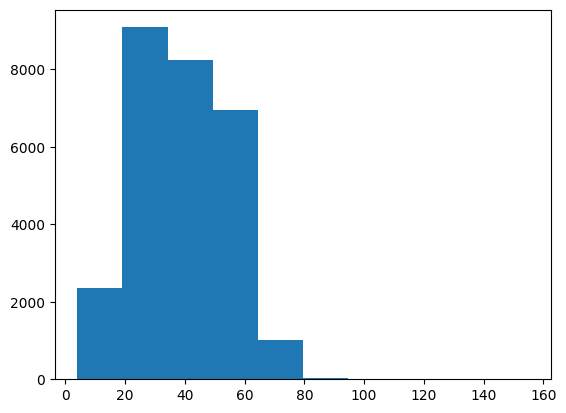

In [147]:
# Length distribution of each summary

text_len_dist = np.asarray([0 if sen is None else len(sen.split()) for sen in df_cleaned['cleaned_text']])

_ = plt.hist(text_len_dist)

In [148]:
print(f"Mean: {np.mean(text_len_dist)}")
print(f"Median: {np.median(text_len_dist)}")
print(f"Max: {np.max(text_len_dist)}")

Mean: 39.36860549132948
Median: 39.0
Max: 155


In [149]:
df_cleaned['overall_sentiment_label'].unique()

array(['Somewhat-Bearish', 'Neutral', 'Somewhat-Bullish', 'Bearish',
       'Bullish'], dtype=object)

In [150]:
label_map = {
    'Bearish': 0,
    'Somewhat-Bearish': 1,
    'Neutral': 2,
    'Somewhat-Bullish': 3,
    'Bullish': 4,
}

for key in list(label_map.keys()):
    df_cleaned.loc[df_cleaned['overall_sentiment_label'] == key, 'overall_sentiment_label'] = label_map[key]

df_cleaned['overall_sentiment_label'] = df_cleaned['overall_sentiment_label']
df_cleaned.dropna(inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

In [151]:
df_cleaned.head()

,cleaned_text,overall_sentiment_label,overall_sentiment_score
0,brazilian clerk allegedly defraud by george sa...,1,-0.273754
1,elizabeth warren want regulator to investigate...,2,-0.071991
2,musk 's twitter rule a dizzying whiplash induc...,1,-0.171335
3,miley cyrus ' ' flower ' become most stream so...,2,0.028594
4,chinese tech giant struggle infographic stock ...,2,0.069711


In [152]:
# Preprocess News dataset
def doc_level_preprocess(doc):
    tokens = set(doc.split(" ")[:MAX_WORDS])
    if '' in tokens:
        tokens.remove('')
    return tokens


# Categorical
df_train = [(x, df_cleaned['overall_sentiment_label'][i]) for i, x in
            enumerate(map(doc_level_preprocess, df_cleaned['cleaned_text']))
            if len(x) >= MIN_WORDS]

# Regression
# df_train = [(x, df_cleaned['overall_sentiment_score'][i]) for i, x in
#             enumerate(map(doc_level_preprocess, df_cleaned['cleaned_text']))
#             if len(x) >= MIN_WORDS]

Loading Glove vectors

In [153]:
def read_glove_vectors(path):
    glo_dict = {}
    with open(path, mode='r', encoding='utf8') as file:
        for line in file.readlines():
            line = line.split(" ")
            glo_dict[line[0]] = np.asarray(line[1:], dtype=np.float32)
    return glo_dict


GLOVE_PATH = "./data/glove.6B.100d.txt"
glo_dict = read_glove_vectors(GLOVE_PATH)

In [154]:
# Finding common words

vant_vocab_set = set()

for news in df_train:
    vant_vocab_set.update(news[0])  # news[0] is news, news[1] is label
glove_set = set(glo_dict.keys())
glove_set &= vant_vocab_set


In [155]:
TRAINABLE_EMB_LAYER = True
glove_token_arr = np.array(sorted(list(glove_set)))

# single numpy array before building a torch Tensor
glove_vec_arr = np.asarray([glo_dict[token] for token in glove_token_arr], dtype=np.float32)
glove_emb_layer = nn.Embedding.from_pretrained(torch.Tensor(glove_vec_arr))
glove_emb_layer.weight.requires_grad = TRAINABLE_EMB_LAYER
# only relevant glove embeddings are in memory.
glove_vec_arr.shape

(22823, 100)

In [156]:
import torch

print(f'CUDA: {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}')

CUDA: True
DEVICE: cuda:0


In [157]:
# build an index array for fetching the word vectors
def doc2ind(doc, max_dim=100):
    token_idx = np.minimum(np.searchsorted(glove_token_arr, doc), len(glove_token_arr) - 1)
    valid_tokens = glove_token_arr[token_idx] == doc
    # pre-padding the vector then filling it with valid indices
    indices = np.zeros(max_dim, dtype=np.int32)
    indices[:sum(valid_tokens)] = token_idx[valid_tokens]
    return indices


# vant_word_embeddings indices
X = torch.LongTensor([doc2ind(list(doc[0]), max_dim=MAX_WORDS) for doc in df_train])
# labels
y = torch.Tensor(np.array([doc[1] for doc in df_train], dtype=np.int32))

In [158]:
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: torch.Size([27678, 64])
y: torch.Size([27678])


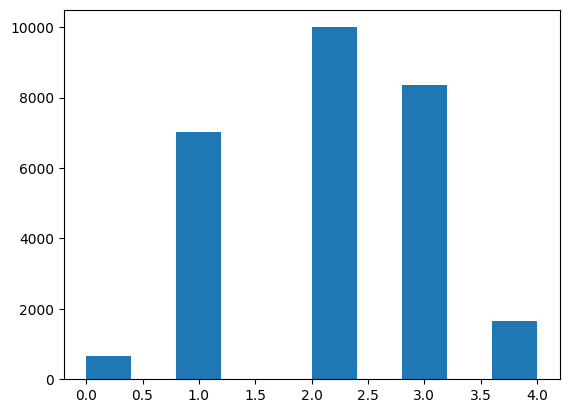

In [159]:
_ = plt.hist(y)

In [160]:
# X_train and X_test are indices and not the actual glove word embeddings.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# To GPU
X_train = torch.Tensor(X_train).to(device)
X_test = torch.Tensor(X_test).to(device)

y_train = torch.Tensor(y_train).to(device)
y_test = torch.Tensor(y_test).to(device)

# Finally Embedding layer to the GPU
glove_emb_layer = glove_emb_layer.to(device)

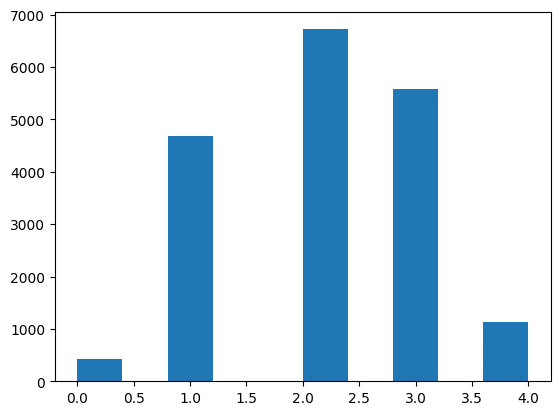

In [161]:
_ = plt.hist(torch.Tensor.cpu(y_train))

In [162]:
BATCH_SIZE = 8192
NUM_LABELS = len(np.unique(y))


# NUM_LABELS = 1 # regression model


def setup_model(num_classes=NUM_LABELS, emb_layer=glove_emb_layer):
    return nn.Sequential(
        emb_layer,
        nn.Flatten(),
        nn.Linear(MAX_WORDS * 100, 2048),
        nn.Dropout(0.05),
        nn.LeakyReLU(),
        nn.Linear(2048, 512),
        nn.Dropout(0.05),
        nn.LeakyReLU(),
        nn.Linear(512, 64),
        nn.LeakyReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

In [163]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs=50, lr=0.0001):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    batch_per_epoch = len(X_train) // BATCH_SIZE

    tr_loss_hist = np.zeros((n_epochs,), dtype=np.float32)
    ts_loss_hist = np.zeros((n_epochs,), dtype=np.float32)
    ts_acc_hist = np.zeros((n_epochs), dtype=np.float32)

    model.train(mode=True)
    for epoch in range(n_epochs):
        print(f'*** EPOCH {epoch} ***')
        tr_loss = 0.

        for i in range(batch_per_epoch):
            st = i * BATCH_SIZE
            X_batch = X_train[st:st + BATCH_SIZE]
            y_batch = y_train[st:st + BATCH_SIZE]
            # predict / forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.to(torch.uint8))
            tr_loss += loss
            # tune / backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

        tr_loss /= batch_per_epoch
        # test
        with torch.no_grad():
            y_pred = model(X_test)
        acc = float((y_pred.argmax(axis=1) == y_test).to(torch.float64).mean())
        test_loss = loss_fn(y_pred, y_test.to(torch.uint8))
        print("Train Loss {:.2f}".format(tr_loss))
        print("Test Loss {:.2f}".format(test_loss))
        print("Test Accuracy {:.2f} \n".format(acc))
        tr_loss_hist[epoch] = tr_loss
        ts_loss_hist[epoch] = test_loss
        ts_acc_hist[epoch] = acc
    return tr_loss_hist, ts_loss_hist, ts_acc_hist

In [164]:
model = setup_model(num_classes=NUM_LABELS)
model = model.to(device)
print(model)

Sequential(
  (0): Embedding(22823, 100)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=6400, out_features=2048, bias=True)
  (3): Dropout(p=0.05, inplace=False)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=2048, out_features=512, bias=True)
  (6): Dropout(p=0.05, inplace=False)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=512, out_features=64, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=64, out_features=5, bias=True)
  (11): Softmax(dim=1)
)


In [165]:
tr_loss_hist, ts_loss_hist, ts_acc_hist = train_model(model, X_train, X_test, y_train, y_test, n_epochs=200)

*** EPOCH 0 ***
Train Loss 1.60
Test Loss 1.57
Test Accuracy 0.36 

*** EPOCH 1 ***
Train Loss 1.56
Test Loss 1.53
Test Accuracy 0.36 

*** EPOCH 2 ***
Train Loss 1.53
Test Loss 1.52
Test Accuracy 0.36 

*** EPOCH 3 ***
Train Loss 1.52
Test Loss 1.52
Test Accuracy 0.36 

*** EPOCH 4 ***
Train Loss 1.51
Test Loss 1.51
Test Accuracy 0.36 

*** EPOCH 5 ***
Train Loss 1.51
Test Loss 1.50
Test Accuracy 0.36 

*** EPOCH 6 ***
Train Loss 1.50
Test Loss 1.50
Test Accuracy 0.37 

*** EPOCH 7 ***
Train Loss 1.50
Test Loss 1.50
Test Accuracy 0.36 

*** EPOCH 8 ***
Train Loss 1.50
Test Loss 1.50
Test Accuracy 0.36 

*** EPOCH 9 ***
Train Loss 1.50
Test Loss 1.50
Test Accuracy 0.36 

*** EPOCH 10 ***
Train Loss 1.50
Test Loss 1.50
Test Accuracy 0.37 

*** EPOCH 11 ***
Train Loss 1.50
Test Loss 1.50
Test Accuracy 0.37 

*** EPOCH 12 ***
Train Loss 1.49
Test Loss 1.49
Test Accuracy 0.37 

*** EPOCH 13 ***
Train Loss 1.49
Test Loss 1.49
Test Accuracy 0.38 

*** EPOCH 14 ***
Train Loss 1.49
Test Loss 1

In [172]:
MODEL_NAME = "2048_ep_200"
torch.save(model, f"./models/{MODEL_NAME}")

In [176]:
training_hist = pd.DataFrame.from_dict({'train_loss': tr_loss_hist, 'test_loss' : ts_loss_hist, 'accuracy': ts_acc_hist})
training_hist.to_csv(f'./models/{MODEL_NAME+'_training_history'}.csv')

In [ ]:
# dense_emb = glove_emb_layer.weight[X].detach().numpy()
# dense_emb = np.reshape(dense_emb, (dense_emb.shape[0], MAX_WORDS * 100))
# dense_emb.shape